In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-salary-3.txt')
data.head()

,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


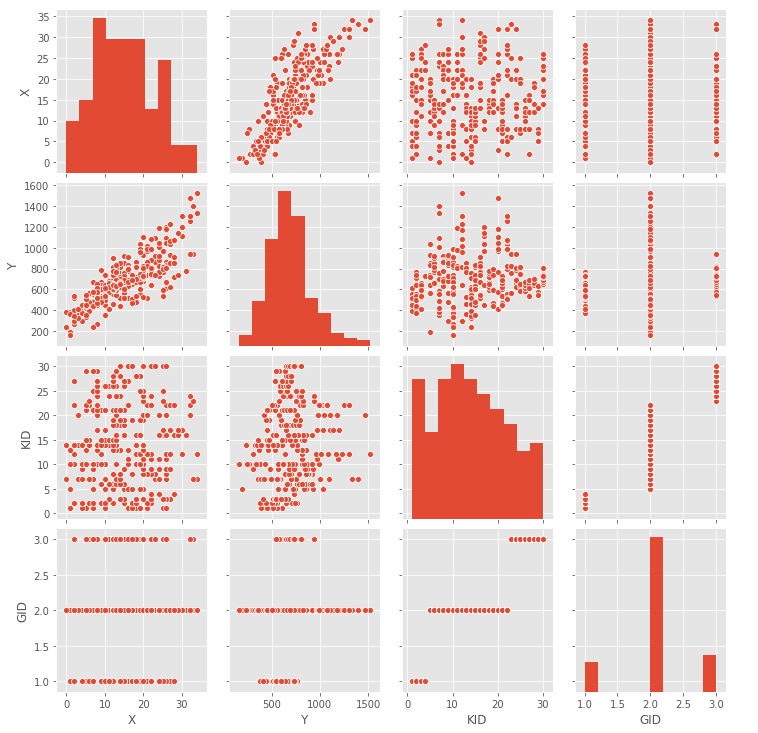

In [3]:
sns.pairplot(data)

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:290: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


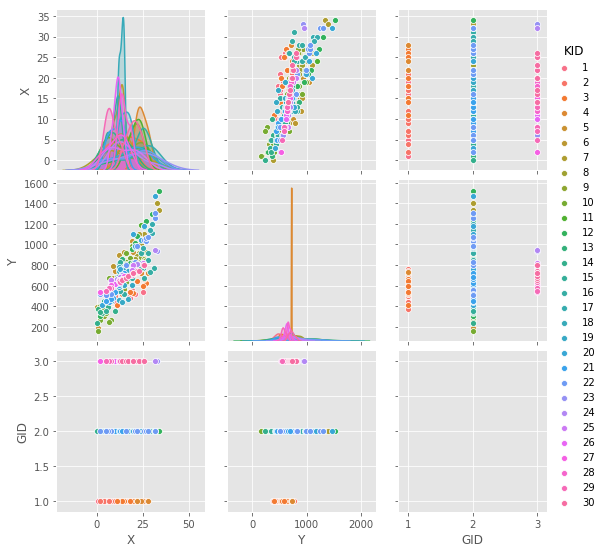

In [4]:
sns.pairplot(data, hue='KID')

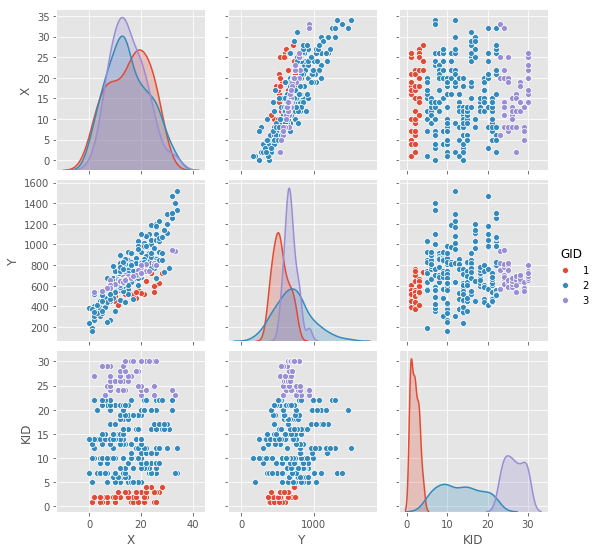

In [5]:
sns.pairplot(data, hue='GID')

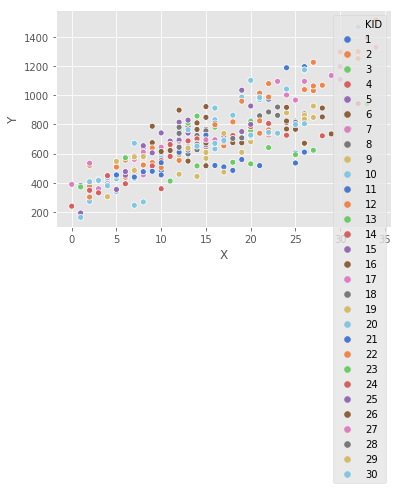

In [6]:
sns.scatterplot(data=data, x='X', y='Y', hue='KID', palette='muted')

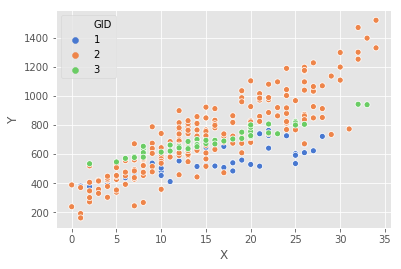

In [7]:
sns.scatterplot(data=data, x='X', y='Y', hue='GID', palette='muted')

In [12]:
stan_model = """

data {
  int N;
  int G;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K]; 
}

parameters {
  real a0;
  real b0;
  real a1[G];
  real b1[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b; 
  real<lower=0> s_Y;
}


model {
  for (g in 1:G){
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(a0, s_bg);    
  }
  
  for (k in 1:K){
    a[k] ~ normal(a1[K2G[k]], s_a);
    b[k] ~ normal(b1[K2G[k]], s_b);   
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[KID[n]] + b[KID[n]] * X[n], s_Y);
  }
}

generated quantities {
  real y_pred[N];
  for (n in 1:N){
    y_pred[n] = normal_rng(a[KID[n]] + b[KID[n]] * X[n], s_Y);
  }
}

"""

In [13]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d382c5dea556cae4e506550e45b3d18a NOW.


In [21]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['G'] = len(data['GID'].unique())
stan_data['K'] = len(data['KID'].unique())
stan_data['X'] = data['X']
stan_data['Y'] = data['Y']
stan_data['KID'] = data['KID']
stan_data['K2G'] = data[['KID', 'GID']].drop_duplicates()['GID']

In [27]:
fit = sm.sampling(stan_data, seed=12345)

In [28]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_d382c5dea556cae4e506550e45b3d18a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0            43.2    5.01  94.85   -34.0  13.34  19.61  28.71 378.04    358   1.01
b0         -2.3e10  2.8e10 6.9e10 -2.0e11 -9.7e9  6.2e7  3.8e9 4.5e10      6   2.42
a1[1]       358.52    1.25  30.96  296.38 338.18  358.7 379.78 419.07    617    1.0
a1[2]       298.35    0.46  13.77  271.24 289.98 298.21 306.34 327.49    884    1.0
a1[3]       502.84    1.26  28.52  446.02 483.16 503.36  523.4 555.17    515   1.01
b1[1]        13.16    0.08   2.79    7.83  11.42  13.07  15.11  18.56   1200    1.0
b1[2]        28.56    0.06   1.38   25.91  27.64  28.56  29.48  31.41    558   1.01
b1[3]        12.37    0.08   2.44    7.56  10.74  12.46  13.91  17.33    934    1.0
a[1]        364

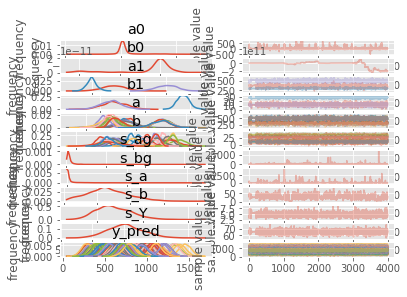

In [29]:
fig = fit.plot()

In [30]:
sample_a = fit.extract('a')['a']
sample_b = fit.extract('b')['b']
sample_y_pred = fit.extract('y_pred')['y_pred']

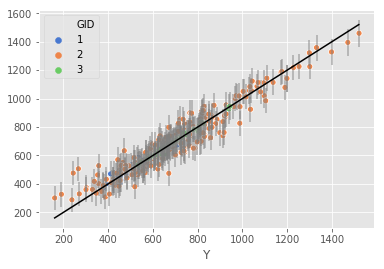

In [31]:
lower80, upper80 = mstats.mquantiles(sample_y_pred, [0.1, 0.9], axis=0)
sample_y_pred_mean = np.mean(sample_y_pred, axis=0)

sns.scatterplot(data['Y'], sample_y_pred_mean, data['GID'], palette='muted')
lower_dist = sample_y_pred_mean - lower80
upper_dist = upper80 -  sample_y_pred_mean
plt.errorbar(data['Y'], sample_y_pred_mean, [lower_dist, upper_dist], ls='', alpha=0.6, color='gray')

x = np.arange(min(data['Y']), max(data['Y']))
y = x
plt.plot(x, y, color='black')

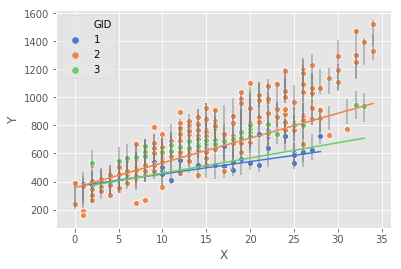

In [33]:
sns.scatterplot(data['X'], data['Y'], hue=data['GID'], palette='muted')
cp = sns.color_palette('muted')

for gid in sorted(data['GID'].unique()):
    data2 = data[data['GID']==gid]
    sample_y_pred_gid = sample_y_pred[:,(data['GID']==gid)]
    sample_a_gid = sample_a[:,gid-1]
    sample_b_gid = sample_b[:,gid-1]
    
    lower80, upper80 = mstats.mquantiles(sample_y_pred_gid, [0.1, 0.9], axis=0)
    sample_y_pred_mean = np.mean(sample_y_pred_gid, axis=0)
    sample_a_mean = np.mean(sample_a_gid, axis=0)
    sample_b_mean = np.mean(sample_b_gid, axis=0)    
    
    sns.scatterplot(data2['X'], data2['Y'], color=cp[gid-1])
    lower_dist = sample_y_pred_mean - lower80
    upper_dist = upper80 -  sample_y_pred_mean
    plt.errorbar(data2['X'], sample_y_pred_mean, [lower_dist, upper_dist], ls='', alpha=0.6, color='gray')

    x = np.arange(min(data2['X']), max(data2['X']+1))
    y = sample_a_mean + sample_b_mean * x
    plt.plot(x, y, color=cp[gid-1])

In [34]:
stan_model2 = """

data {
  int N;
  int G;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K]; 
  int<lower=1, upper=G> GID[N];
}

parameters {
  real a0;
  real b0;
  real a1[G];
  real b1[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a[G];
  real<lower=0> s_b[G]; 
  real<lower=0> s_Y[G];
}


model {
  for (g in 1:G){
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(a0, s_bg);    
  }
  
  for (k in 1:K){
    a[k] ~ normal(a1[K2G[k]], s_a[K2G[k]]);
    b[k] ~ normal(b1[K2G[k]], s_b[K2G[k]]);   
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[KID[n]] + b[KID[n]] * X[n], s_Y[GID[n]]);
  }
}

generated quantities {
  real y_pred[N];
  for (n in 1:N){
    y_pred[n] = normal_rng(a[KID[n]] + b[KID[n]] * X[n], s_Y[GID[n]]);
  }
}

"""

In [35]:
sm2 = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d382c5dea556cae4e506550e45b3d18a NOW.


In [36]:
stan_data['GID'] = data['GID']

In [37]:
fit2 = sm2.sampling(stan_data, seed=12345)

In [38]:
fit2


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_d382c5dea556cae4e506550e45b3d18a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0            43.2    5.01  94.85   -34.0  13.34  19.61  28.71 378.04    358   1.01
b0         -2.3e10  2.8e10 6.9e10 -2.0e11 -9.7e9  6.2e7  3.8e9 4.5e10      6   2.42
a1[1]       358.52    1.25  30.96  296.38 338.18  358.7 379.78 419.07    617    1.0
a1[2]       298.35    0.46  13.77  271.24 289.98 298.21 306.34 327.49    884    1.0
a1[3]       502.84    1.26  28.52  446.02 483.16 503.36  523.4 555.17    515   1.01
b1[1]        13.16    0.08   2.79    7.83  11.42  13.07  15.11  18.56   1200    1.0
b1[2]        28.56    0.06   1.38   25.91  27.64  28.56  29.48  31.41    558   1.01
b1[3]        12.37    0.08   2.44    7.56  10.74  12.46  13.91  17.33    934    1.0
a[1]        364

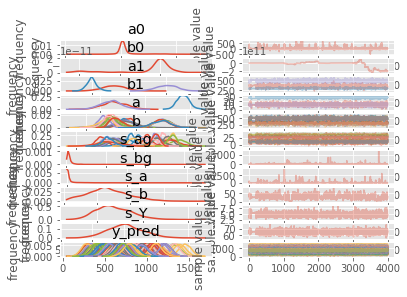

In [39]:
fig = fit2.plot()

In [40]:
sample_a_2 = fit2.extract('a')['a']
sample_b_2 = fit2.extract('b')['b']
sample_y_pred_2 = fit2.extract('y_pred')['y_pred']

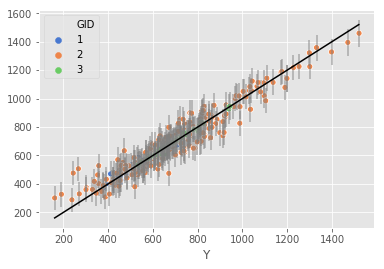

In [41]:
lower80_2, upper80_2 = mstats.mquantiles(sample_y_pred_2, [0.1, 0.9], axis=0)
sample_y_pred_mean_2 = np.mean(sample_y_pred_2, axis=0)

sns.scatterplot(data['Y'], sample_y_pred_mean_2, data['GID'], palette='muted')
lower_dist_2 = sample_y_pred_mean_2 - lower80_2
upper_dist_2 = upper80_2 -  sample_y_pred_mean_2
plt.errorbar(data['Y'], sample_y_pred_mean_2, [lower_dist_2, upper_dist_2], ls='', alpha=0.6, color='gray')

x = np.arange(min(data['Y']), max(data['Y']))
y = x
plt.plot(x, y, color='black')

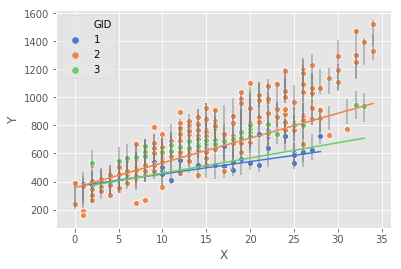

In [42]:
sns.scatterplot(data['X'], data['Y'], hue=data['GID'], palette='muted')
cp = sns.color_palette('muted')

for gid in sorted(data['GID'].unique()):
    data2 = data[data['GID']==gid]
    sample_y_pred_2_gid = sample_y_pred_2[:,(data['GID']==gid)]
    sample_a_2_gid = sample_a_2[:,gid-1]
    sample_b_2_gid = sample_b_2[:,gid-1]
    
    lower80, upper80 = mstats.mquantiles(sample_y_pred_2_gid, [0.1, 0.9], axis=0)
    sample_y_pred_mean_2 = np.mean(sample_y_pred_2_gid, axis=0)
    sample_a_mean_2 = np.mean(sample_a_2_gid, axis=0)
    sample_b_mean_2 = np.mean(sample_b_2_gid, axis=0)    
    
    sns.scatterplot(data2['X'], data2['Y'], color=cp[gid-1])
    lower_dist = sample_y_pred_mean_2 - lower80
    upper_dist = upper80 -  sample_y_pred_mean_2
    plt.errorbar(data2['X'], sample_y_pred_mean_2, [lower_dist, upper_dist], ls='', alpha=0.6, color='gray')

    x = np.arange(min(data2['X']), max(data2['X']+1))
    y = sample_a_mean_2 + sample_b_mean_2 * x
    plt.plot(x, y, color=cp[gid-1])